# Classification MNIST numbers 3, 4 and 5 Using a Multilayer Perceptron (MLP) Neural Network

In [1]:
# Import necessary libraries
import numpy as np  # For numerical operations and data manipulation
import matplotlib.pyplot as plt  # For plotting and visualizations
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  # For confusion matrix generation and display

# Keras for building and training the neural network
from keras.models import Sequential  # For defining sequential neural network model
from keras.layers import Dense, Input  # Input for defining input layer and Dense for fully connected layers
from keras.utils import to_categorical  # For one-hot encoding of the target labels

# TensorFlow's MNIST dataset
from tensorflow.keras.datasets import mnist  # For loading MNIST dataset

# SciPy for additional statistical functions
from scipy.stats import entropy  # To calculate entropy for feature extraction

In [2]:
# Load and preprocess the MNIST dataset, filtering only digits 3, 4, and 5
def load_and_filter_mnist():
    # Load MNIST dataset (train and test sets)
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    # Normalize pixel values to the range [0, 1]
    x_train = x_train / 255.0
    x_test = x_test / 255.0

    # Filter for images of digits 3, 4, and 5
    train_filter = np.isin(y_train, [3, 4, 5])
    test_filter = np.isin(y_test, [3, 4, 5])

    # Apply the filters to the training and test sets
    x_train_filtered = x_train[train_filter]
    y_train_filtered = y_train[train_filter] - 3  # Reassign labels to 0, 1, 2 for better handling
    x_test_filtered = x_test[test_filter]
    y_test_filtered = y_test[test_filter] - 3  # Reassign labels to 0, 1, 2

    # Convert labels to one-hot encoding
    y_train_categorical = to_categorical(y_train_filtered, num_classes=3)
    y_test_categorical = to_categorical(y_test_filtered, num_classes=3)

    # Return the filtered and preprocessed training and test sets
    return (x_train_filtered, y_train_categorical), (x_test_filtered, y_test_categorical)

In [3]:
# Feature extraction methods for image columns

def median_column(image):
    # Calculate the median value of each column in the image
    return np.median(image, axis=0)

def variance_column(image):
    # Calculate the variance of each column in the image
    return np.var(image, axis=0)

def entropy_column(image):
    # Calculate the entropy for each column using pixel histograms
    return np.array([entropy(np.histogram(image[:, i], bins=256)[0]) for i in range(image.shape[1])])

def iqr_column(image):
    # Calculate the Interquartile Range (IQR) for each column
    q75, q25 = np.percentile(image, [75, 25], axis=0)
    return q75 - q25

def correlation_column(image, reference_column):
    # Calculate the correlation of each column with a reference column
    correlations = []
    for i in range(image.shape[1]):
        std_image = np.std(image[:, i])
        std_ref = np.std(reference_column)
        # Check if either standard deviation is zero to avoid division by zero
        if std_image == 0 or std_ref == 0:
            correlations.append(0)  # Return 0 when correlation is undefined
        else:
            correlation = np.corrcoef(image[:, i], reference_column)[0, 1]
            correlations.append(correlation)
    return np.array(correlations)

In [4]:
# Define the Multilayer Perceptron (MLP) model
def create_mlp_model():
    model = Sequential()  # Initialize a sequential model
    
    # Input layer with 28 features (one for each column of the image)
    model.add(Input(shape=(28,)))
    
    # Hidden layer with 28 neurons and ReLU activation function
    model.add(Dense(28, activation='relu'))
    
    # Output layer with 3 neurons (one for each class: digits 3, 4, 5), using softmax activation
    model.add(Dense(3, activation='softmax'))
    
    # Compile the model using categorical crossentropy loss, Adam optimizer, and accuracy as a metric
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model  # Return the compiled model

In [5]:
# Plot training and validation accuracy/loss for the given feature extraction method
def plot_history(history, feature_name):
    # Create a figure with 2 subplots (Accuracy and Loss)
    plt.figure(figsize=(12, 4))
    
    # Plot model accuracy for both training and validation sets
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')  # Training accuracy
    plt.plot(history.history['val_accuracy'], label='Test')  # Validation accuracy
    plt.title(f'{feature_name} - Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')  # Show legend
    
    # Plot model loss for both training and validation sets
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')  # Training loss
    plt.plot(history.history['val_loss'], label='Test')  # Validation loss
    plt.title(f'{feature_name} - Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')  # Show legend

    # Display the plots
    plt.show()

In [6]:
# Evaluate the model performance and plot the confusion matrix
def evaluate_model(model, x_test, y_test, feature_name):
    # Predict the classes for the test set
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels
    y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class labels

    # Generate the confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)

    # Display the confusion matrix with labeled axes (digits 3, 4, 5)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[3, 4, 5])
    disp.plot(cmap=plt.cm.Blues)  # Plot using a blue color map
    plt.title(f'{feature_name} - Confusion Matrix')  # Title indicating the feature extraction method
    plt.show()  # Show the plot

In [7]:
# Plot random test images with their predicted and actual labels for visual comparison
def plot_predictions(model, x_test_features, x_test_original, y_test, num_samples=10):
    # Predict labels for the test set using the trained model
    y_pred = model.predict(x_test_features)
    predicted_labels = np.argmax(y_pred, axis=1)  # Convert predicted probabilities to class labels
    test_labels = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class labels
    
    # Reassign predicted and true labels from 0, 1, 2 back to 3, 4, 5
    predicted_labels = predicted_labels + 3
    test_labels = test_labels + 3
    
    # Select random samples from the test set for visualization
    indices = np.random.choice(np.arange(len(x_test_original)), num_samples, replace=False)
    test_images = x_test_original[indices]  # Select the corresponding test images
    test_labels_sample = test_labels[indices]  # Select the corresponding true labels
    predicted_labels_sample = predicted_labels[indices]  # Select the corresponding predicted labels
    
    # Plot the randomly selected test images with their predicted and actual labels
    plt.figure(figsize=(20, 5))  # Create a figure with a specific size
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)  # Create a subplot for each image
        plt.imshow(test_images[i], cmap='gray')  # Display the image in grayscale
        plt.title(f"Pred: {predicted_labels_sample[i]}\nActual: {test_labels_sample[i]}")  # Show predicted vs actual label
        plt.axis('off')  # Hide axis for better visualization
    
    plt.show()  # Display the plot

In [8]:
# Train the MLP model, evaluate its performance, and plot accuracy, loss, and predictions
def train_and_evaluate_model(x_train, y_train, x_test, y_test, feature_name, x_test_original):
    # Create the MLP model
    model = create_mlp_model()
    
    # Train the model on the training data and validate on the test data
    history = model.fit(x_train, y_train, epochs=30, batch_size=32, validation_data=(x_test, y_test), verbose=0)
    
    # Plot training and validation accuracy and loss curves
    plot_history(history, feature_name)
    
    # Evaluate the model performance and plot confusion matrix
    evaluate_model(model, x_test, y_test, feature_name)
    
    # Plot random test images with predicted and actual labels
    plot_predictions(model, x_test, x_test_original, y_test)

In [9]:
# Load dataset, apply different feature extraction methods, and train/evaluate the MLP model for each
def run_all_models():
    # Load and preprocess the MNIST dataset, filtering only digits 3, 4, and 5
    (x_train_filtered, y_train_categorical), (x_test_filtered, y_test_categorical) = load_and_filter_mnist()
    
    # Calculate the reference column by averaging over all images for the correlation method
    reference_column = np.mean(np.mean(x_train_filtered, axis=0), axis=1)
    
    # Define different feature extraction methods to apply to each image column
    feature_extraction_methods = {
        'Median': median_column,  # Median values per column
        'Variance': variance_column,  # Variance values per column
        'Entropy': entropy_column,  # Entropy values per column
        'IQR': iqr_column,  # Interquartile range values per column
        'Correlation': lambda img: correlation_column(img, reference_column)  # Correlation with reference column
    }
    
    # Iterate over each feature extraction method, apply it to the dataset, and train/evaluate the model
    for feature_name, extraction_method in feature_extraction_methods.items():
        print(f'\nRunning model for {feature_name} feature extraction...')
        
        # Extract features for both training and test datasets
        x_train_features = np.array([extraction_method(img) for img in x_train_filtered])
        x_test_features = np.array([extraction_method(img) for img in x_test_filtered])
        
        # Train and evaluate the model with the extracted features and the original test set for visualization
        train_and_evaluate_model(x_train_features, y_train_categorical, x_test_features, y_test_categorical, feature_name, x_test_filtered)


Running model for Median feature extraction...


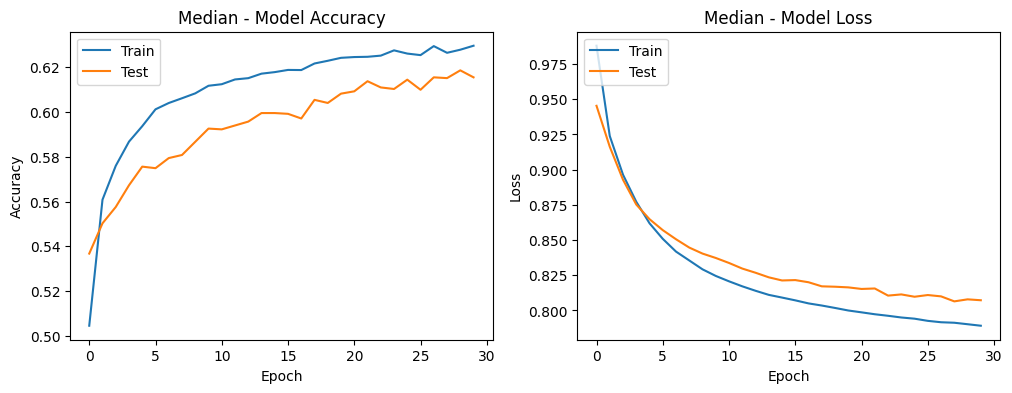

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


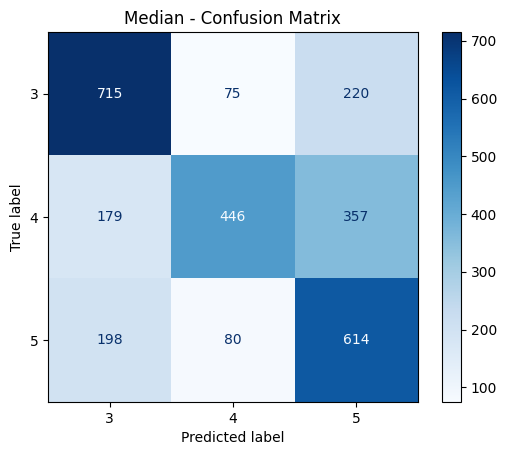

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


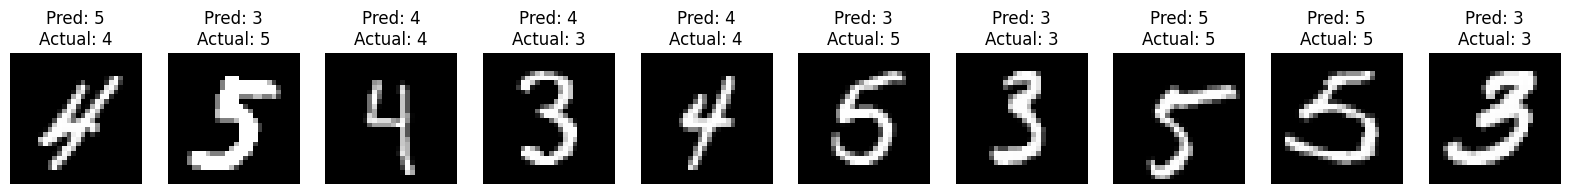


Running model for Variance feature extraction...


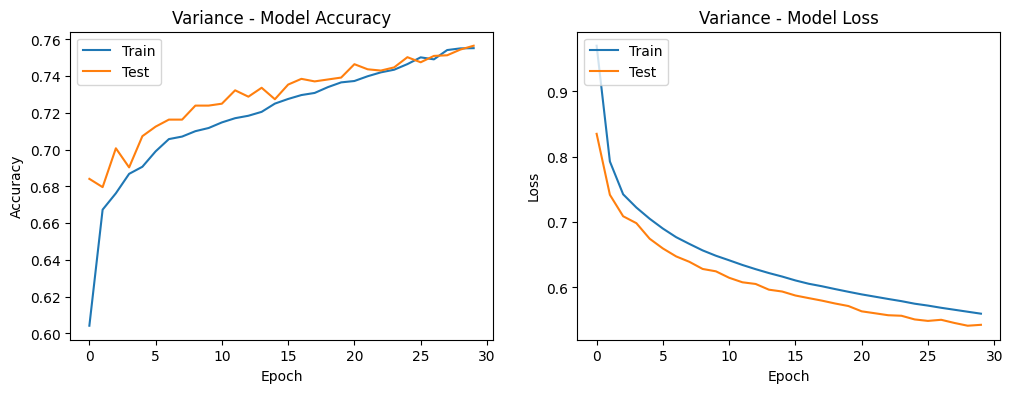

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


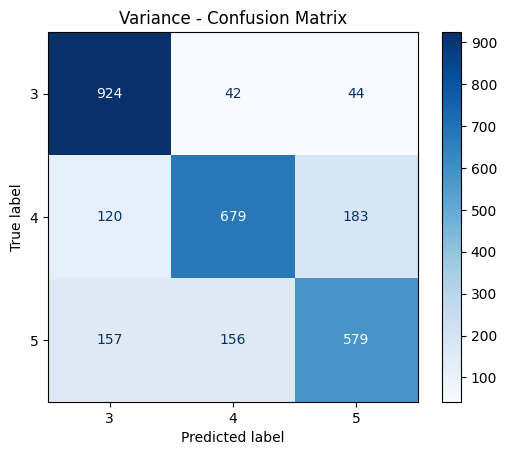

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


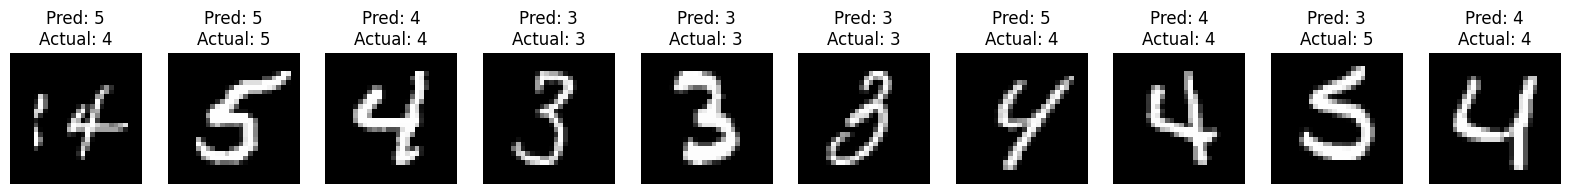


Running model for Entropy feature extraction...


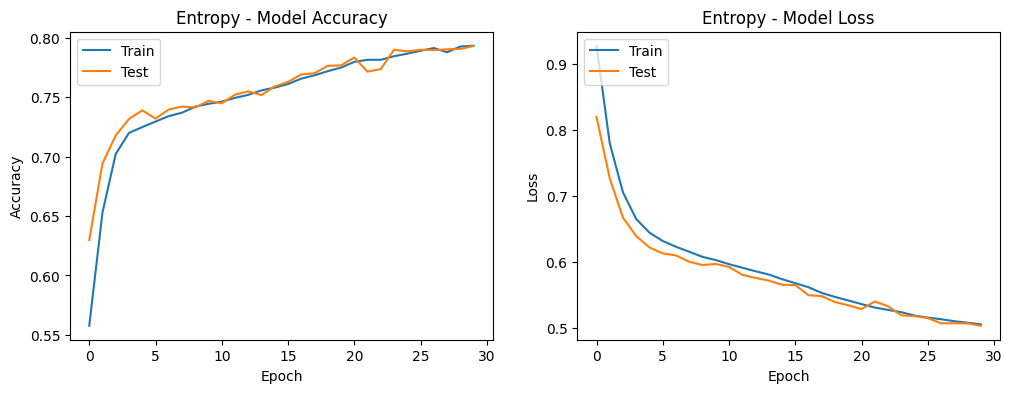

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


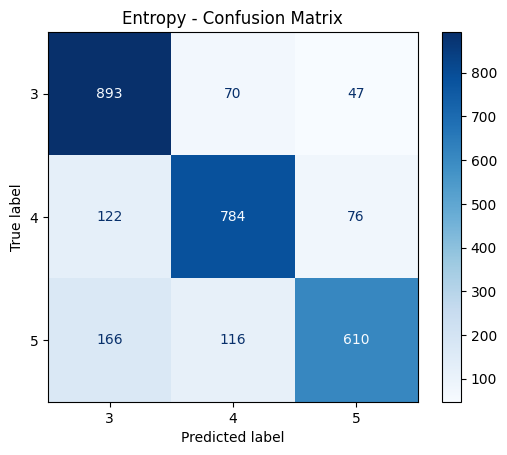

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


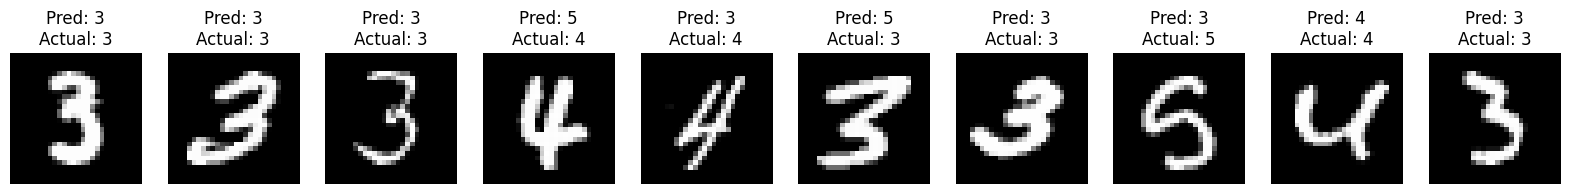


Running model for IQR feature extraction...


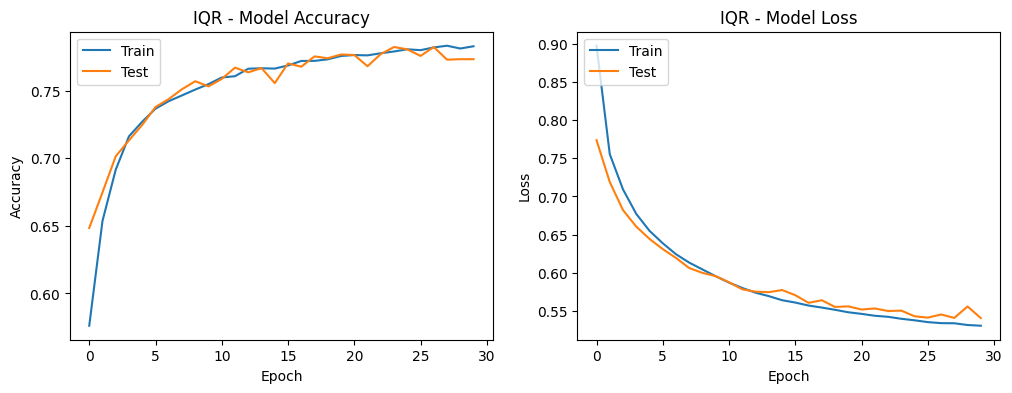

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


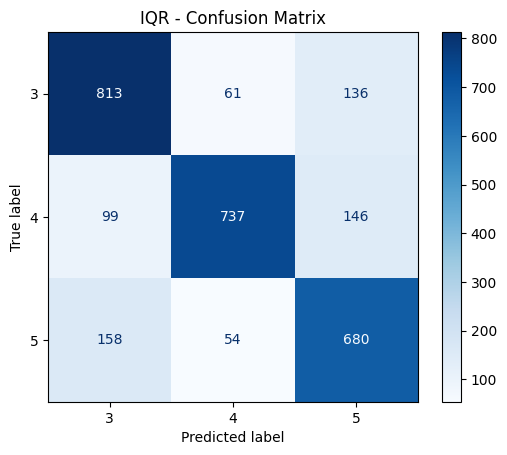

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


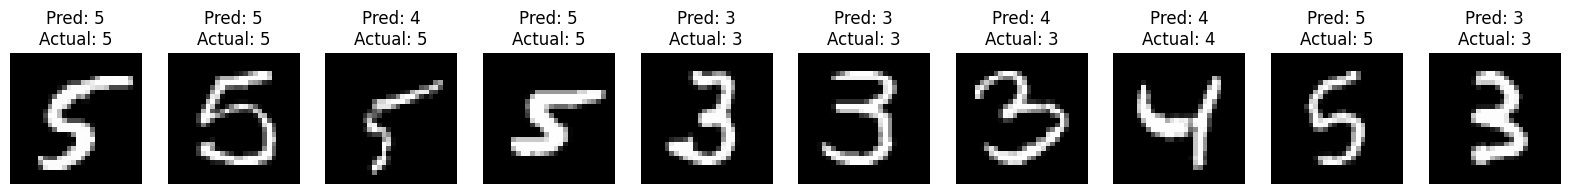


Running model for Correlation feature extraction...


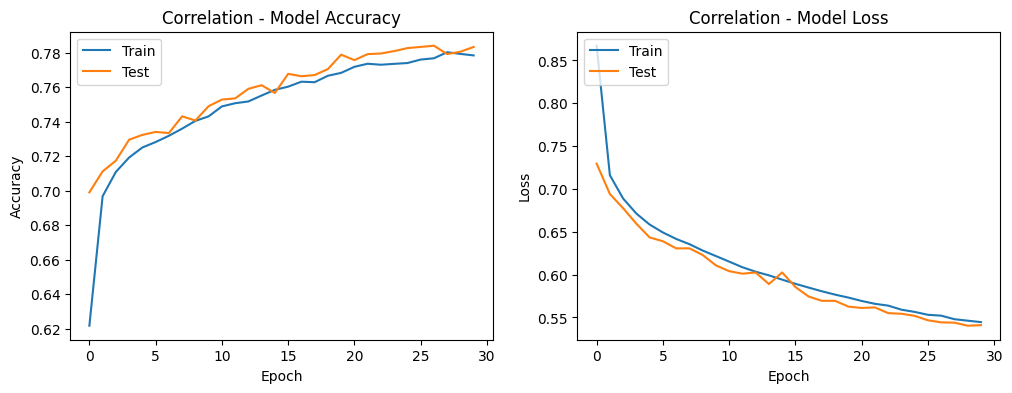

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


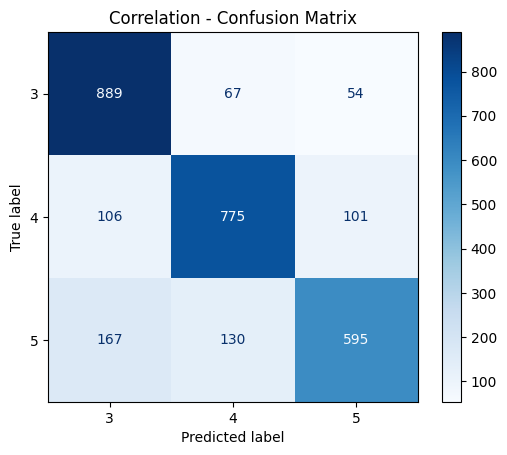

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step


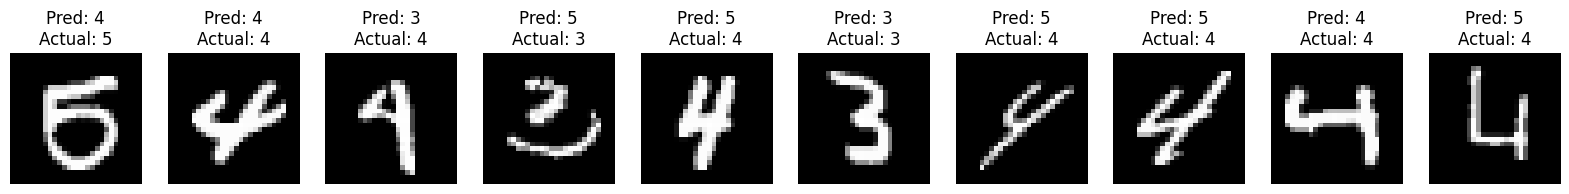

In [10]:
# Run all feature extraction methods, train, and evaluate the models systematically
run_all_models()